In [2]:
# dependencies

import gzip
from pickle import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from switch import sde, types
from switch.models import tanh

sns.set_theme()

In [3]:
# load f109 data

f109 = pd.read_csv('paper/f109.csv', sep=',', parse_dates=['date']).iloc[:, 1:]
f109

,date,cumTime,centerE,centerN
0,2009-01-18,0.00000,0.000,0.000
1,2009-01-18,0.99984,0.018,-0.066
2,2009-01-18,1.99992,0.010,-0.078
3,2009-01-18,3.01656,0.030,-0.213
4,2009-01-23,123.73320,-0.381,-0.383
...,...,...,...,...
3914,2012-08-30,31672.71648,12.198,-10.904
3915,2012-08-30,31677.71664,12.033,-8.594
3916,2012-08-30,31683.08328,12.040,-8.597
3917,2012-08-30,31683.61656,12.041,-8.592


In [ ]:
# plot f109 data || figure 3

plt.figure(figsize=(2*(1+np.sqrt(5)), 2))
plt.plot(f109.date.values[f109.date.dt.year == 2009], f109.centerE[f109.date.dt.year == 2009], linewidth=1)
plt.xlabel(None)
plt.ylabel('East-West Coordinate')

plt.savefig('paper/f109_data.pdf', backend='pgf', bbox_inches='tight')

In [ ]:
# load MCMC output

n_thin = 10
n_discard = 10000

with gzip.open('paper/f109_mcmc_samples.pkl', 'rb') as f:
    samples = load(f)

thi, lam, h = zip(*samples[n_discard // n_thin::])

In [ ]:
# zoomed in trajectory inference plot || figure 1

def sample_trajectory(grid_t, sample, mod, ome):
    grid_vt = []
    for t0, t1, v0, v1, y0 in zip(sample[2].t, sample[2].t[1:], sample[2].vt, sample[2].vt[1:], sample[2].yt):
        grid_t_ = grid_t[(t0 <= grid_t) & (grid_t < t1)]
        if len(grid_t_) > 0:
            grid_vt.append(sde.sample_bridge(sample[0], grid_t_ - t0, t1 - t0, y0, v0, v1, mod, ome))
    return np.hstack(grid_vt)

t0 = pd.to_datetime('2009-12-20')
t1 = pd.to_datetime('2009-12-30')
t = f109.cumTime.values[f109.date.dt.year == 2009]
vt = f109.centerE.values[f109.date.dt.year == 2009]
grid_t = np.linspace(*f109.cumTime.values[(f109.date > t0) & (f109.date <= t1)][[0, -1]], 256)
grid_vt = [sample_trajectory(grid_t, sample_, tanh.mod, np.random.default_rng(0)) for sample_ in samples]

y = [types.prune_anchorage(h_) for h_ in h[::10]]
jump_t = np.sort(np.unique(np.hstack([y_.t for y_ in y])))
jump_yt = np.array([np.bincount(t_, minlength=thi[0].shape[0]) / len(y) for t_ in zip(*[y_(jump_t) for y_ in y])])
jump_date = (f109.date.iloc[0] + pd.to_timedelta(jump_t, unit='h')).to_series()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(2*(1+np.sqrt(5)), 4))

ax1.plot(f109.date.iloc[0] + pd.to_timedelta(grid_t, unit='h'), np.median(grid_vt, axis=0), linewidth=1)
ax1.fill_between(f109.date.iloc[0] + pd.to_timedelta(grid_t, unit='h'), *np.percentile(grid_vt, (12.5, 87.5), axis=0), alpha=.25)
ax1.scatter(f109.date.iloc[0] + pd.to_timedelta(t[(t >= grid_t[0]) & (t <= grid_t[-1])], unit='h'), vt[(t >= grid_t[0]) & (t <= grid_t[-1])], color=sns.color_palette()[0], s=16)
ax1.set_xticks(ax1.get_xticks()[::2])
ax1.set_xticklabels([])
ax1.set_ylabel('East-West')

ax2.plot(jump_date[(jump_date >= t0) & (jump_date <= t1)], jump_yt[(jump_date >= t0) & (jump_date <= t1), 0], linewidth=1)
ax2.set_xticks(ax1.get_xticks())
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylabel('Prob. of "Resting"')

plt.savefig('paper/f109_mcmc_latent.pdf', backend='pgf', bbox_inches='tight')

In [ ]:
# MCMC parameter trace plot || figure 4

df = []
for i in range(thi[0].shape[0]):
    thi_ = np.array([thi_[i] for thi_ in thi])
    # lam_ = np.array([np.diag(lam_)[i] for lam_ in lam])    
    df_ = pd.DataFrame({'mu': thi_[:, 0], 'beta': thi_[:, 1], 'rho': thi_[:, 2]})
    df_['state'] = str(i)
    df_['iter'] = (n_discard + df_.index) * n_thin
    df.append(df_)
df_long = pd.concat(df, axis=0).melt(id_vars=['iter', 'state'], var_name='param')
df_long['tag'] = df_long.param + '_' + df_long.state

g = sns.relplot(data=df_long, x='iter', y='value', hue='state', col='tag', col_wrap=3, kind='line', linewidth=1, aspect=(1+np.sqrt(5))/2, height=2, legend=False, facet_kws={'sharey': False}, col_order=df_long.sort_values(['state', 'param']).tag.unique())
g.set(ylabel=None)
g.set_titles(col_template=r'$\{col_name}$')
g.axes[3].set(xlabel='Iteration')
g.axes[4].set(xlabel=None)
g.axes[5].set(xlabel=None)

plt.savefig('paper/f109_mcmc_traces.pdf', backend='pgf', bbox_inches='tight')

In [4]:
# load MCEM output

with gzip.open('paper/f109_mcem_samples.pkl', 'rb') as f:
    estimates = load(f)

obj, thi, lam = zip(*estimates)
orders = [np.argsort(s[:, -1]) for s in thi]
thi = [s[o] for s, o in zip(thi, orders)]
lam = [s[o][:, o] for s, o in zip(lam, orders)]

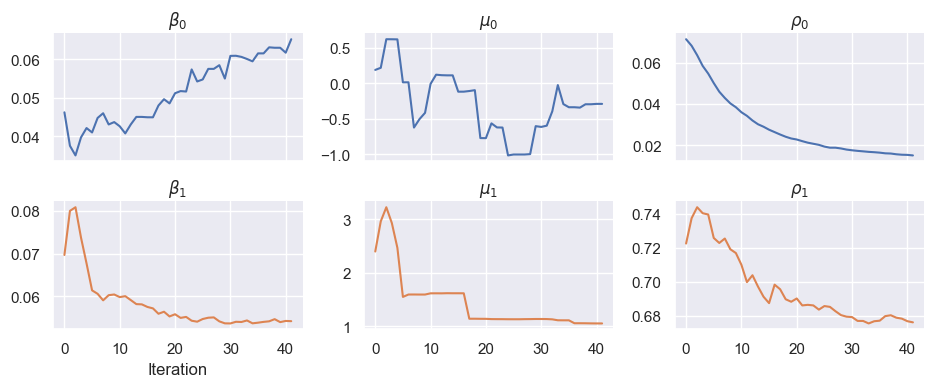

In [5]:
# MCEM parameter trace plot || figure 5

df = []
for i in range(thi[0].shape[0]):
    thi_ = np.array([thi_[i] for thi_ in thi])
    df_ = pd.DataFrame({'mu': thi_[:, 0], 'beta': thi_[:, 1], 'rho': thi_[:, 2]})
    df_['state'] = str(i)
    df_['iter'] = df_.index
    df.append(df_)
df_long = pd.concat(df, axis=0).melt(id_vars=['iter', 'state'], var_name='param')
df_long['tag'] = df_long.param + '_' + df_long.state

g = sns.relplot(data=df_long, x='iter', y='value', hue='state', col='tag', col_wrap=3, kind='line', aspect=(1+np.sqrt(5))/2, height=2, legend=False, facet_kws={'sharey': False}, col_order=df_long.sort_values(['state', 'param']).tag.unique().tolist())
g.set(ylabel=None)
g.set_titles(col_template=r'$\{col_name}$')
g.axes[3].set(xlabel='Iteration')
g.axes[4].set(xlabel=None)
g.axes[5].set(xlabel=None)

plt.savefig('paper/f109_mcem_params.pdf', backend='pgf', bbox_inches='tight')

In [ ]:
# parameter marginals plot || figure 6

def format_samples(src, meta, n_thin, n_discard):
    with gzip.open(src, 'rb') as f:
        samples = load(f)
    thi, lam = list(zip(*samples[n_discard // n_thin::]))[:2]
    orders = [np.argsort(s[:, 2]) for s in thi]
    thi = [s[o] for s, o in zip(thi, orders)]
    lam = [s[o][:, o] for s, o in zip(lam, orders)]
    df = []
    for i in range(thi[0].shape[0]):
        thi_ = np.array([thi_[i] for thi_ in thi])
        lam_ = np.array([np.diag(lam_)[i] for lam_ in lam])
        df_ = pd.DataFrame({'mu': thi_[:, 0], 'beta': thi_[:, 1], 'rho': thi_[:, 2], 'lambda': -lam_})
        df_['state'] = str(i)
        df_['iter'] = (n_discard + df_.index) * n_thin
        df.append(df_)
    df_long = pd.concat(df, axis=0).melt(id_vars=['iter', 'state'], var_name='param')
    df_long['tag'] = df_long.param + '_' + df_long.state
    for key, value in meta.items():
        df_long[key] = value
    return df_long

targets = (
    ('paper/f109_approx_samples.pkl', {'algo': 'rate0'}), 
    ('paper/f109_impute4_samples.pkl', {'algo': 'rate4'}), 
    ('paper/f109_mcmc_samples.pkl', {'algo': 'exact'}))
df_long = pd.concat([format_samples(*targets_, n_thin, n_discard) for targets_ in targets]).reset_index(drop=True)

g = sns.displot(data=df_long.loc[df_long.param != 'lambda'], x='value', hue='algo', col='tag', fill=True, col_wrap=3, kind='kde', aspect=(1+np.sqrt(5))/2, height=2, legend=False, bw_method=.33, common_norm=False, facet_kws={'sharex': False, 'sharey': False}, col_order=df_long.loc[df_long.param != 'lambda'].sort_values(['state', 'param']).tag.unique().tolist(), palette='magma')
g.set(ylabel=None)
g.set_titles(col_template=r'$\{col_name}$')
g.axes[3].set(xlabel=None)
g.axes[4].set(xlabel=None)
g.axes[5].set(xlabel=None)

plt.savefig('paper/f109_bias.pdf', backend='pgf', bbox_inches='tight')